In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample

from tensorflow import keras, squeeze, round
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.layers.experimental.preprocessing import TextVectorization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import L2
from keras.metrics import BinaryAccuracy, AUC

import matplotlib.pyplot as plt
# https://nlpretext.readthedocs.io/en/latest/
# for twitter
# https://towardsdatascience.com/twitter-sentiment-analysis-classification-using-nltk-python-fa912578614c
#from nlpretext import Preprocessor
#from nlpretext.basic.preprocess import normalize_whitespace, remove_punct, remove_eol_characters, remove_stopwords, \
#   lower_text, remove_accents, remove_multiple_spaces_and_strip_text, replace_numbers, replace_emails, replace_urls
#from nlpretext.social.preprocess import convert_emoji_to_text, remove_mentions, extract_mentions, remove_hashtag, extract_hashtags

from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords
# some useful libraries
# spacy

np.random.seed(42)

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DAVID\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DAVID\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")

In [4]:
print(train_data.shape)
print(train_data["text"][5])
print(train_data["target"][5])

(7613, 5)
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
1


In [115]:
# DONT RUN
# text pre-processing
counter = 0
def get_str_hashtags(text):
    preprocessor = Preprocessor()
    preprocessor.pipe(extract_hashtags)
    lst = preprocessor.run(text)    
    str = ""
    for word in lst:
        str += " " + word.replace('#', '')
    return str

def get_str_mentions(text):
    preprocessor = Preprocessor()
    preprocessor.pipe(extract_mentions)
    lst = preprocessor.run(text)
    str = ""
    for word in lst:
        str += " " + word.replace('@', '')
    return str
    

def clean_text(text):
    preprocessor = Preprocessor()
    preprocessor.pipe(lower_text)
    preprocessor.pipe(remove_mentions)
    preprocessor.pipe(remove_hashtag)
    preprocessor.pipe(convert_emoji_to_text)
    preprocessor.pipe(remove_eol_characters)
    preprocessor.pipe(remove_stopwords, args={'lang': 'en'})
    preprocessor.pipe(remove_punct)
    preprocessor.pipe(replace_urls)
    preprocessor.pipe(replace_emails)
    preprocessor.pipe(replace_numbers)
    preprocessor.pipe(remove_accents)
    preprocessor.pipe(remove_multiple_spaces_and_strip_text)
    preprocessor.pipe(normalize_whitespace)
    
    text = preprocessor.run(text)

    return text

In [24]:
def clean_text(tweet):
    tweet_blob = TextBlob(tweet)
    tweet_blob = ' '.join(tweet_blob.words)
    tweet_blob = tweet_blob.lower()
    stopset = set(stopwords.words('english'))
    cleanup = " ".join(filter(lambda word: word not in stopset, tweet_blob.split()))
    return cleanup

print(clean_text(train_data["text"].iloc[5]))
print(train_data["text"].iloc[5])

rockyfire update california hwy 20 closed directions due lake county fire cafire wildfires
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires


In [6]:
# clean train data and save it to a csv
train_data['clean_text'] = train_data.text.apply(lambda x: clean_text(x))
#train_data['hashtags'] = train_data.text.apply(lambda x: get_str_hashtags(x))
#train_data['mentions'] = train_data.text.apply(lambda x: get_str_mentions(x))
train_data.to_csv('train_clean.csv')


In [7]:
# clean test data and save it to a csv
test_data['clean_text'] = test_data.text.apply(lambda x: clean_text(x))
#test_data['hashtags'] = test_data.text.apply(lambda x: get_str_hashtags(x))
#test_data['mentions'] = test_data.text.apply(lambda x: get_str_mentions(x))
test_data.to_csv('test_clean.csv')

In [10]:
df = pd.read_csv("./train_clean.csv")
print(df.shape)

(7613, 7)


The test data does not have a target column, so we cannot evaluate our models using the test data. We need to split the first dataset into a test and train dataset.

In [11]:
# split the data into train and test set
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in sss.split(df, df['target']):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]

print(df_train.shape)
print(df_test.shape)
print(df_train.target.value_counts()/len(df_train))
print(df_test.target.value_counts()/len(df_test))

(5329, 7)
(2284, 7)
0    0.570276
1    0.429724
Name: target, dtype: float64
0    0.57049
1    0.42951
Name: target, dtype: float64


In [12]:
# reset indexes
df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [13]:
cleaned_train_text = list(df_train["clean_text"])
labels_train = list(df_train["target"])
cleaned_test_text = list(df_test["clean_text"])
labels_test = list(df_test["target"])

In [14]:
# After cleaning the text, some value are NaN. So, we need to replace these values with an empty string
train_nan_indexes = df_train[df_train["clean_text"].isna()].index
for i in train_nan_indexes:
    cleaned_train_text[i] = ""

test_nan_indexes = df_test[df_test["clean_text"].isna()].index
for i in test_nan_indexes:
    cleaned_test_text[i] = ""

In [15]:
# tokenize the clean_text column
maxlen = 30
max_words = 100
vocab_size = 100
# word level one-hot encoding
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(cleaned_train_text)
sequences = tokenizer.texts_to_sequences(cleaned_train_text)
#one_hot_results = tokenizer.texts_to_matrix(cleaned_train_text, mode='binary')
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens")

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels_train)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print(data.shape[0])


Found 17427 unique tokens
Shape of data tensor: (5329, 30)
Shape of label tensor: (5329,)
5329


In [16]:
# using the GloVe word-embeddings file from https://nlp.stanford.edu/projects/glove/
glove_dir = './'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), 'r', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [17]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [18]:
test_word = 'earthquake'
test_vector = embeddings_index[test_word]
print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word earthquake looks like this:

[-0.093032   1.6301     0.36645    0.29015   -0.81781   -0.46611
  0.037282   0.13208    0.13661    1.2091     0.81466   -0.12874
  0.52387   -0.024319   0.94072   -0.12509   -0.34087    0.19321
 -1.0522     0.62915   -0.0699     0.14182    0.49985    0.61688
  0.027162   0.22695   -0.89086    1.4411    -0.45774   -0.5922
  0.48147   -0.4387     0.99552    1.3003    -1.1123    -1.4847
  0.53476   -0.22524   -0.21366   -0.14612   -0.50853    0.82284
 -0.075167  -0.60331    0.86412    0.15815    0.76075   -0.28173
  0.27679   -0.43729   -0.53438    0.081051   0.98763   -0.28154
 -0.15944   -1.9562     0.13058   -0.46506    1.4629     1.262
 -0.46154    1.3625    -0.40815   -0.24256    0.21117    0.57007
 -1.6566    -0.21043    0.97449   -0.16146   -0.33706    0.50539
  0.45718    0.2184     0.69558    0.43774    0.4584     0.57097
 -0.17801    0.15078    0.46262    0.46737   -0.76256   -0.0044911
  0.146      0.20688    0.10127  

In [ ]:
# DONT RUN
hashtags_train = list(df_train["hashtags"])
hashtags_test = list(df_test["hashtags"])
mentions_train = list(df_train["mentions"])
mentions_test = list(df_test["mentions"])

In [ ]:
# DONT RUN
# Some value are NaN. So, we need to replace these values with an empty string
train_nan_indexes = df_train[df_train["hashtags"].isna()].index
for i in train_nan_indexes:
    hashtags_train[i] = ""
train_nan_indexes = df_train[df_train["mentions"].isna()].index
for i in train_nan_indexes:
    mentions_train[i] = ""
    
test_nan_indexes = df_test[df_test["hashtags"].isna()].index
for i in test_nan_indexes:
    hashtags_test[i] = ""
test_nan_indexes = df_test[df_test["mentions"].isna()].index
for i in test_nan_indexes:
    mentions_test[i] = ""

In [56]:
# DONT RUN
# tokenize hashtags column
maxlen = 100
max_words = 10000
vocab_size = 10000
# word level one-hot encoding
tokenizer_hashtags = Tokenizer(num_words=vocab_size)
tokenizer_hashtags.fit_on_texts(hashtags_train)
sequences_hashtags = tokenizer.texts_to_sequences(hashtags_train)
#one_hot_results = tokenizer.texts_to_matrix(hashtags_train, mode='binary')
word_index = tokenizer_hashtags.word_index
print(f"Found {len(word_index)} unique tokens")

data_hashtags = pad_sequences(sequences_hashtags, maxlen=maxlen)


Found 1459 unique tokens


In [57]:
# DONT RUN
# tokeize mentions column
maxlen = 248
max_words = 1000
vocab_size = 1000
# word level one-hot encoding
tokenizer_mentions = Tokenizer(num_words=vocab_size)
tokenizer_mentions.fit_on_texts(mentions_train)
sequences_mentions = tokenizer.texts_to_sequences(mentions_train)
#one_hot_results = tokenizer.texts_to_matrix(hashtags_train, mode='binary')
word_index = tokenizer_mentions.word_index
print(f"Found {len(word_index)} unique tokens")

data_mentions = pad_sequences(sequences_mentions, maxlen=maxlen)

Found 1853 unique tokens


In [19]:
input1 = keras.Input(shape=(None,))
input2 = keras.Input(shape=(None,))
input3 = keras.Input(shape=(None,))
input = layers.Concatenate()([input1, input2, input3])
# https://stackoverflow.com/questions/55233377/keras-sequential-model-with-multiple-inputs
# embed_layer = layers.Embedding(
#         input_dim=vocab_size,
#         output_dim=maxlen,
#     )(input)
embed_layer = layers.Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
        input_length=maxlen
    )(input1)
#x = layers.Bidirectional(layers.SimpleRNN(64, return_sequences=True, kernel_regularizer = L2(0.001)))(embed_layer)
x = layers.SimpleRNN(64, return_sequences=True, kernel_regularizer = L2(0.001))(embed_layer)
x = layers.Dropout(0.5)(x)
#x = layers.Bidirectional(layers.SimpleRNN(32, kernel_regularizer = L2(l2=0.001)))(x)
x = layers.SimpleRNN(32, kernel_regularizer = L2(l2=0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

#model = keras.models.Model(inputs=[input1, input2, input3], outputs=output)
model = keras.models.Model(inputs=input1, outputs=output)
#model.summary()
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics="accuracy")

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=3,
    verbose=0,
    mode='min'
)

# checkpoints = ModelCheckpoint(
#     '/kaggle/working/best_model.h5',
#     monitor='val_loss',
#     verbose=0,
#     save_best_only=True,
#     mode='min'
# )

early_stop = EarlyStopping(
    patience=5,
    min_delta=0,
    monitor='val_loss',
    #restore_best_weights=True,
    verbose=0,
    mode='min',
    baseline=None
)

# history = model.fit([data, data_hashtags, data_mentions], labels, 
#                     validation_split=0.3, epochs=50, batch_size=64, callbacks=[reduce_lr,early_stop])
history = model.fit(data, labels, 
                    validation_split=0.3, epochs=50, batch_size=64, callbacks=[reduce_lr,early_stop])

Epoch 1/50
59/59 [==============================] - 3s 17ms/step - loss: 0.8446 - accuracy: 0.5611 - val_loss: 0.7722 - val_accuracy: 0.6141 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 1s 13ms/step - loss: 0.8026 - accuracy: 0.5882 - val_loss: 0.7600 - val_accuracy: 0.6185 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 1s 12ms/step - loss: 0.7880 - accuracy: 0.5909 - val_loss: 0.7492 - val_accuracy: 0.6210 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 1s 12ms/step - loss: 0.7642 - accuracy: 0.6011 - val_loss: 0.7431 - val_accuracy: 0.6335 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 1s 12ms/step - loss: 0.7597 - accuracy: 0.6185 - val_loss: 0.7338 - val_accuracy: 0.6310 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 1s 12ms/step - loss: 0.7397 - accuracy: 0.6365 - val_loss: 0.7172 - val_accuracy: 0.6560 - lr: 0.0010
Epoch 7/50
59/59 [==============================] - 1s 13ms/step - loss: 0.7

In [ ]:
# trying recurrent layer
# model = keras.models.Sequential()
# model.add(layers.Input(shape=(None,)))
# model.add(layers.Embedding(input_dim=vocab_size, output_dim=300, mask_zero=True))
# model.add(layers.Bidirectional(layers.SimpleRNN(32, return_sequences=True)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Bidirectional(layers.SimpleRNN(32)))
# model.add(layers.Dense(1, activation='sigmoid'))
# model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics="accuracy")
# history = model.fit(data, labels, validation_split=0.3, epochs=5, batch_size=32)

model = keras.models.Sequential()
model.add(layers.Input(shape=(None,)))
model.add(layers.Embedding(input_dim=max_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
        input_length=maxlen))
#model.add(layers.Bidirectional(layers.SimpleRNN(32, return_sequences=True)))
model.add(layers.SimpleRNN(64))
#model.add(layers.Dropout(0.5))
#model.add(layers.Bidirectional(layers.SimpleRNN(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics="accuracy")
history = model.fit(data, labels, validation_split=0.3, epochs=20, batch_size=32)


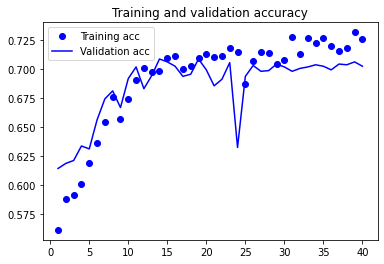

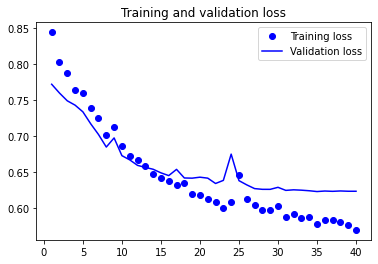

In [20]:
# plotting the model fit
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
# using LSTM layer
model2 = keras.models.Sequential()
model2.add(layers.Input(shape=(None,)))
#model2.add(layers.Embedding(input_dim=vocab_size, output_dim=300, mask_zero=True))
model2.add(layers.Embedding(input_dim=max_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
        input_length=maxlen))
# model2.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
# model2.add(layers.Dropout(0.5))
model2.add(layers.LSTM(64))

model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics="accuracy")
history2 = model2.fit(data, labels, validation_split=0.3, epochs=5, batch_size=64)

Epoch 1/5
59/59 [==============================] - 3s 28ms/step - loss: 0.6199 - accuracy: 0.6598 - val_loss: 0.6174 - val_accuracy: 0.6667
Epoch 2/5
59/59 [==============================] - 1s 22ms/step - loss: 0.5760 - accuracy: 0.6973 - val_loss: 0.6328 - val_accuracy: 0.6423
Epoch 3/5
59/59 [==============================] - 1s 21ms/step - loss: 0.5643 - accuracy: 0.7021 - val_loss: 0.5852 - val_accuracy: 0.6986
Epoch 4/5
59/59 [==============================] - 1s 21ms/step - loss: 0.5583 - accuracy: 0.7091 - val_loss: 0.6347 - val_accuracy: 0.6760
Epoch 5/5
59/59 [==============================] - 1s 21ms/step - loss: 0.5527 - accuracy: 0.7099 - val_loss: 0.6422 - val_accuracy: 0.6617


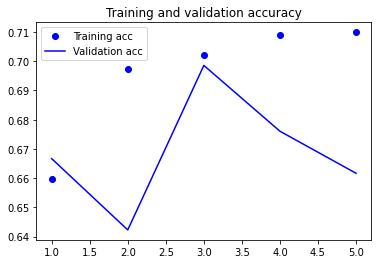

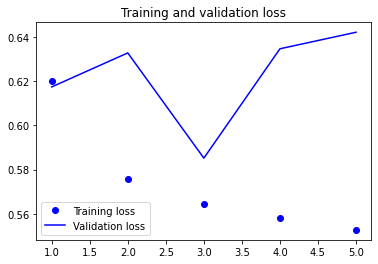

In [26]:
# plotting the model fit
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
# Tokenizing the test data split
# word level one-hot encoding
test_tokenizer = Tokenizer(num_words=vocab_size, lower=False)
test_tokenizer.fit_on_texts(cleaned_test_text)
test_sequences = test_tokenizer.texts_to_sequences(cleaned_test_text)
test_one_hot_results = test_tokenizer.texts_to_matrix(cleaned_test_text, mode='binary')
test_word_index = test_tokenizer.word_index
print(f"Found {len(test_word_index)} unique tokens")

test_data = pad_sequences(test_sequences, maxlen=maxlen)

labels_test = np.asarray(labels_test)
print('Shape of data tensor:', test_data.shape)
print('Shape of label tensor:', labels_test.shape)


Found 9358 unique tokens
Shape of data tensor: (2284, 30)
Shape of label tensor: (2284,)


In [65]:
# DONT RUN
#Tokenizing the test data split for hashtags
test_tokenizer_hashtags = Tokenizer(num_words=vocab_size, lower=False)
test_tokenizer_hashtags.fit_on_texts(hashtags_test)
test_sequences_hashtags = test_tokenizer_hashtags.texts_to_sequences(hashtags_test)
#test_one_hot_results = test_tokenizer_hashtags.texts_to_matrix(hashtags_test, mode='binary')
test_word_index = test_tokenizer_hashtags.word_index
#print(f"Found {len(test_word_index)} unique tokens")

test_data_hashtags = pad_sequences(test_sequences_hashtags, maxlen=maxlen)

print('Shape of data tensor:', test_data_hashtags.shape)

Shape of data tensor: (2284, 100)


In [66]:
# DONT RUN
#Tokenizing the test data split for mentions
test_tokenizer_mentions = Tokenizer(num_words=vocab_size, lower=False)
test_tokenizer_mentions.fit_on_texts(mentions_test)
test_sequences_mentions = test_tokenizer_mentions.texts_to_sequences(mentions_test)
#test_one_hot_results = test_tokenizer_mentions.texts_to_matrix(mentions_test, mode='binary')
test_word_index = test_tokenizer_mentions.word_index
#print(f"Found {len(test_word_index)} unique tokens")

test_data_mentions = pad_sequences(test_sequences_mentions, maxlen=maxlen)

print('Shape of data tensor:', test_data_mentions.shape)

Shape of data tensor: (2284, 100)


In [23]:
# evaluate the model on the test data
#test_evals = model.evaluate([test_data, test_data_hashtags, test_data_mentions], labels_test)
test_evals = model.evaluate(test_data, labels_test)
print(test_evals)
# predict on the test data
predictions = model.predict(test_data)
predicted_lbls = squeeze(round(predictions))
print(predicted_lbls)
cr = classification_report(labels_test, predicted_lbls)
print(cr)

72/72 [==============================] - 0s 3ms/step - loss: 0.7482 - accuracy: 0.6033
[0.7481586337089539, 0.6033275127410889]
tf.Tensor([1. 0. 0. ... 0. 0. 1.], shape=(2284,), dtype=float32)
              precision    recall  f1-score   support

           0       0.61      0.85      0.71      1303
           1       0.58      0.27      0.37       981

    accuracy                           0.60      2284
   macro avg       0.60      0.56      0.54      2284
weighted avg       0.60      0.60      0.56      2284



In [27]:
# evaluate the model on the test data
test_evals2 = model2.evaluate(test_data, labels_test)
print(test_evals2)
# predict on the test data
predictions2 = model2.predict(test_data)
predicted_lbls2 = squeeze(round(predictions2))
cr2 = classification_report(labels_test, predicted_lbls2)
print(cr2)

72/72 [==============================] - 0s 5ms/step - loss: 0.7233 - accuracy: 0.6322
[0.7233312726020813, 0.6322241425514221]
              precision    recall  f1-score   support

           0       0.73      0.56      0.64      1303
           1       0.56      0.72      0.63       981

    accuracy                           0.63      2284
   macro avg       0.64      0.64      0.63      2284
weighted avg       0.66      0.63      0.63      2284



The following is to create a submission for the Kaggle Competition

In [ ]:
# create a submission using test data
test_data_clean = pd.read_csv("test_clean.csv")
cleaned_test_text = list(test_data_clean["clean_text"])
test_data_clean = test_data_clean.replace(test_data_clean[test_data_clean['clean_text'].isna()].index, '')
print(test_data_clean.shape)
cleaned_test_text = list(test_data_clean["clean_text"])
nanIndexes = test_data_clean[test_data_clean['clean_text'].isna()].index
for i in nanIndexes:
    cleaned_test_text[i] = ""
maxlen = 100
max_words = 10000
vocab_size = 1000
# word level one-hot encoding
test_tokenizer = Tokenizer(num_words=vocab_size, lower=False)
test_tokenizer.fit_on_texts(cleaned_test_text)
test_sequences = test_tokenizer.texts_to_sequences(cleaned_test_text)
test_one_hot_results = test_tokenizer.texts_to_matrix(cleaned_test_text, mode='binary')
test_word_index = test_tokenizer.word_index
#print(f"Found {len(test_word_index)} unique tokens")

test_data = pad_sequences(test_sequences, maxlen=maxlen)

print('Shape of data tensor:', data.shape)

predictions = model.predict(test_data)
predictions = list(map(lambda x: 0 if x<0.5 else 1, predictions))


res = []
for i in test_data_clean.index:
    res.append([test_data_clean["id"][i], predictions[i]])
predictions_df = pd.DataFrame(res, columns=["id", "target"])
predictions_df.to_csv("./model2predictions.csv", index=False)
